### Proof-of-concept 

**Show the sensitivity of future DM-heated exoplanet searches to the inner slope of the DM density profile**

Question : Could we reconstruct the inner slope of the DM density profile using a future DM-heated exoplanet signal? With which uncertainty?

Assumptions:
- All exoplanets are heavy brown dwarfs with mass $75M_{jup}$, radius $R=R_{jup}$ and age of 10 Gyr
- Emissivity $\epsilon=1$
- Mock observations acount for XX% uncertainty in temperature
- Reconstruction of sensitivity only accounts for XX% uncertainty in temperature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c, R_jup, M_jup, G, GM_jup, sigma_sb
import astropy.units as u
from scipy.special import hyp2f1
from scipy.interpolate import interp1d
from matplotlib import rc
rc('font', family='times new roman', size=22.)
#rc('text', usetex=True)
from matplotlib.offsetbox import AnchoredText
import cmocean
import pickle

In [2]:
test = 1. * u.GeV*u.km*u.m**2/u.cm**3/u.s
test.to(u.W)

<Quantity 0.16021766 W>

In [2]:
# Conversion TW into W
heat_int = 1.1e9 *u.TW
heat_int = heat_int.to(u.W)
print(heat_int)
# Escape velocity exoplanet
vesc = np.sqrt(2*G*M_jup/R_jup)
print(vesc.to(u.km/u.s))

1.1e+21 W
59.53214006549496 km / s


In [3]:
def vc(Rsun, Rint, parameters):
    data = np.genfromtxt("./data/rc_e2bulge_R08.178_J_corr.dat", unpack=True)
    r = data[0]
    vB = data[1]
    data = np.genfromtxt("./data/rc_hgdisc_R08.178_corr.dat", unpack=True)
    vD = data[1]
    vDM = vgNFW(Rsun, r, parameters)
    vtot = np.sqrt(np.power(vB, 2) + np.power(vD, 2)+ np.power(vDM, 2))
    vtot_intp = interp1d(r, vtot)
    return vtot_intp(Rint)

def vgNFW(Rsun, R, parameters):
    """
    Rotation velocity for gNFW dark matter density profile
    """
    # gNFW parameters
    gamma = parameters[0]
    Rs    = parameters[1]
    rho0  = parameters[2] 
    v     = []; 
    for Rint in R:
        hyp=np.float(hyp2f1(3-gamma,3-gamma,4-gamma,-Rint/Rs))
        Integral=(-2**(2+3*gamma)*np.pi*Rint**(3-gamma)*(1+
                  Rsun*(1./Rs))**(3-gamma)*rho0*hyp)/(-3+gamma)
        v.append(np.sqrt(1.18997*10.**(-31.)*Integral/Rint)*3.08567758*10.**(16.))
    v = np.array(v,dtype=np.float64)      
    # Return
    return v

def gNFW_rho(Rsun, R, parameters):
    """
    Return gNFW density profile at r distance from the GC
    Denstiy has same units as local DM density rho0
    """
    # gNFW parameters
    gamma = parameters[0] 
    Rs    = parameters[1]
    rho0  = parameters[2]
    # Density profile
    rho   = rho0*np.power(Rsun/R, gamma)*np.power((Rs+Rsun)/(Rs+R), 3-gamma)    
    # Return
    return rho
    
def heat_DM(r, f=1, R=R_jup, M=M_jup, Rsun=8.178, parameters=[1., 20., 0.42]):
    """
    Heat flow due to DM capture and annihilation
    """
    vesc   = (np.sqrt(2*G*M/R)).value*1e-3 # m/s 
    _vD    = np.sqrt(3/2.)*vc(Rsun, r, parameters) # km/s
    _vDM   =  np.sqrt(8./(3*np.pi))*_vD * u.km/u.s # km/s
    _rhoDM = gNFW_rho(Rsun, r, parameters) * u.GeV/u.cm**3 # GeV/cm3
    # return
    return ((f*np.pi*R**2*_rhoDM*_vDM*(1+3./2.*np.power(vesc/_vD, 2))).to(u.W)).value

def temperature(r, heat_int, f=1, R=R_jup, M=M_jup, parameters=[1., 20., 0.42], epsilon=1):
    """
    Exoplanet temperature
    """
    return (np.power(((heat_int + heat_DM(r, f=f, R=R, M=M, parameters=parameters))*u.W)/
                     (4*np.pi*R**2*sigma_sb*epsilon), 1./4.)).value

**Check Galactic rotation curve**

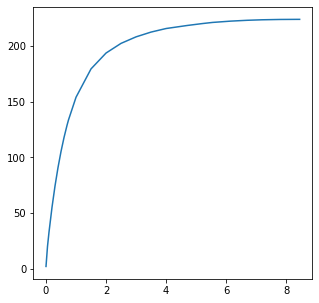

In [44]:
r = np.arange(0.001, 8.5, 0.05)
v = []
for i in range(len(r)):
    v.append(vc(8.178, r[i], [1., 20., 0.42]))
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(r, v)

**Check DM induced exoplanet heat flow**

We assume two benchmarks:
- Heavy brown dwarf with $M=75M_{jup}$
- Jupiter

In [86]:
r = np.arange(0.001, 8.5, 0.05)
heat1 = np.zeros(len(r))
heat75 = np.zeros(len(r))
for i in range(len(r)):
    heat1[i] = heat_DM(r[i]) # W
    heat75[i] = heat_DM(r[i], M=75*M_jup)

Text(0.5, 0, 'r [kpc]')

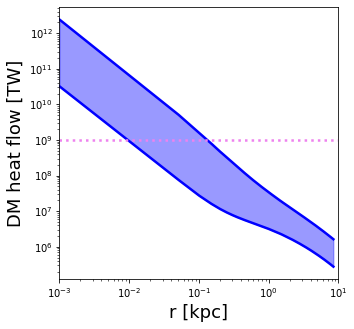

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(r, heat1*1e-12, color="blue", lw=2.5)
ax.plot(r, heat75*1e-12, color="blue", lw=2.5)
ax.fill_between(r, heat1*1e-12, heat75*1e-12, color="blue", alpha=0.4)
ax.axhline(1e9, color="violet", lw=2.5, ls=":")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([0.001, 10])
ax.set_ylabel("DM heat flow [TW]", fontsize=18)
ax.set_xlabel("r [kpc]", fontsize=18)

**Exoplanet temperature**

- Assume heavy brown dwarf with $M=75M_{jup}$

In [63]:
print (temperature(0.001, M=75*M_jup))
print (np.power(1e21*u.W/(4*np.pi*R_jup**2*sigma_sb), 1./4.))

5065.898694910213
723.878831191043 K


In [89]:
r = np.arange(0.01, 8.5, 0.01)
T75 = []
T1  = []
for i in range(len(r)):
    T75.append(temperature(r[i], 1.1e21, M=75*M_jup))
    T1.append(temperature(r[i], 1.4e17, M=M_jup))

(0.01, 10)

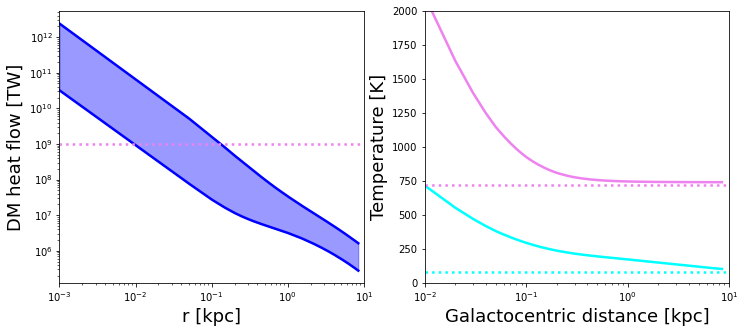

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(np.arange(0.001, 8.5, 0.05), heat1*1e-12, color="blue", lw=2.5)
ax[0].plot(np.arange(0.001, 8.5, 0.05), heat75*1e-12, color="blue", lw=2.5)
ax[0].fill_between(np.arange(0.001, 8.5, 0.05), heat1*1e-12, heat75*1e-12, color="blue", alpha=0.4)
ax[0].axhline(1e9, color="violet", lw=2.5, ls=":")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlim([0.001, 10])
ax[0].set_ylabel("DM heat flow [TW]", fontsize=18)
ax[0].set_xlabel("r [kpc]", fontsize=18)

ax[1].plot(r, T75, color="violet", lw=2.5)
ax[1].plot(r, T1, color="cyan", lw=2.5)
ax[1].axhline(np.power(1e21*u.W/(4*np.pi*R_jup**2*sigma_sb), 1./4.).value, color="violet", lw=2.5, ls=":")
ax[1].axhline(80, color="cyan", lw=2.5, ls=":")
ax[1].set_xscale("log")
ax[1].set_ylabel("Temperature [K]", fontsize=18)
ax[1].set_xlabel("Galactocentric distance [kpc]", fontsize=18)
ax[1].set_ylim([0, 2000])
ax[1].set_xlim([0.01, 10])

The following plot assumes that $v_c(r)$ is only gas + stars

(0.01, 10)

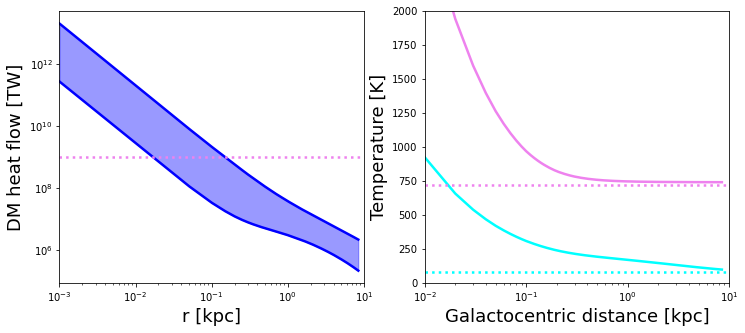

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(np.arange(0.001, 8.5, 0.05), heat1*1e-12, color="blue", lw=2.5)
ax[0].plot(np.arange(0.001, 8.5, 0.05), heat75*1e-12, color="blue", lw=2.5)
ax[0].fill_between(np.arange(0.001, 8.5, 0.05), heat1*1e-12, heat75*1e-12, color="blue", alpha=0.4)
ax[0].axhline(1e9, color="violet", lw=2.5, ls=":")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlim([0.001, 10])
ax[0].set_ylabel("DM heat flow [TW]", fontsize=18)
ax[0].set_xlabel("r [kpc]", fontsize=18)

ax[1].plot(r, T75, color="violet", lw=2.5)
ax[1].plot(r, T1, color="cyan", lw=2.5)
ax[1].axhline(np.power(1e21*u.W/(4*np.pi*R_jup**2*sigma_sb), 1./4.).value, color="violet", lw=2.5, ls=":")
ax[1].axhline(80, color="cyan", lw=2.5, ls=":")
ax[1].set_xscale("log")
ax[1].set_ylabel("Temperature [K]", fontsize=18)
ax[1].set_xlabel("Galactocentric distance [kpc]", fontsize=18)
ax[1].set_ylim([0, 2000])
ax[1].set_xlim([0.01, 10])

**Generation of mock observations**

In [10]:
from scipy.stats import loguniform

Text(0.5, 0, 'Galactocentric distance [kpc]')

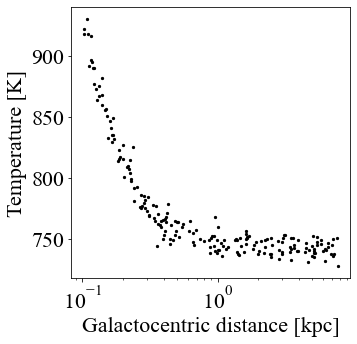

In [47]:
#r_obs       = np.random.uniform(low=0.1, high=8.178, size=200)
np.random.seed(42)
r_obs       = loguniform.rvs(0.1, 8.178, size=200)
gamma_model = 1
f_model     = 1
M_model     = 75*M_jup
R_model     = R_jup
heat_int    = 1.1e21 # W
t_fiducial  = temperature(r_obs, heat_int, f=f_model, R=R_model, M=M_model, 
                          parameters=[gamma_model, 20., 0.42], epsilon=1)
sigma_obs = 0.1*t_fiducial
t_obs     = t_fiducial + 0.1*np.random.normal(loc=0, scale=(0.1*t_fiducial), size=len(t_fiducial))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(r_obs, t_obs, color="k", s=5)
#ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Galactocentric distance [kpc]")

#fig.savefig("Figs/mock_obs_temperature.pdf", bbox_inches="tight")

**Fitting**

In [48]:
from scipy.stats import chi2

def p_value(chi2_score, df):
    return 1 - chi2.cdf(chi2_score, dof)

In [49]:
step = 0.01
f = np.arange(0, 1+step, step)
step = 0.01
gamma = np.arange(0.01, 2+step, step)

print(len(gamma), len(f))
p_gammaf = np.zeros((len(gamma), len(f)))
chi2_gammaf = np.zeros((len(gamma), len(f)))
print(p_gammaf.shape)

dof = len(t_obs)

for i in range(len(gamma)):
    for j in range(len(f)):
        t_model = temperature(r_obs, 1.1e21, f=f[j], M=75*M_jup, parameters=[gamma[i], 20., 0.42])
        chi2_score = np.sum(np.power((t_obs - t_model)/sigma_obs, 2))
        chi2_gammaf[i][j] = chi2_score
        p_gammaf[i][j] = p_value(chi2_score, dof)
pos_min_gammaf = np.where(chi2_gammaf == np.min(chi2_gammaf))
chi2min_gammaf = chi2_gammaf[pos_min_gammaf]

200 101
(200, 101)


In [12]:
step = 0.5
rs = np.arange(5, 30, step)

print(len(gamma), len(rs))
p_gammars = np.zeros((len(gamma), len(rs)))
chi2_gammars = np.zeros((len(gamma), len(rs)))
print(p_gammars.shape)

dof = len(t_obs)

for i in range(len(gamma)):
    for j in range(len(rs)):
        t_model = temperature(r_obs, 1.1e21, f=1, M=75*M_jup, parameters=[gamma[i], rs[j], 0.42])
        chi2_score = np.sum(np.power((t_obs - t_model)/sigma_obs, 2))
        chi2_gammars[i][j] = chi2_score
        p_gammars[i][j] = p_value(chi2_score, dof)
pos_min_gammars = np.where(chi2_gammars == np.min(chi2_gammars))
chi2min_gammars = chi2_gammars[pos_min_gammars]

200 50
(200, 50)


**Results**

In [15]:
dof   = 2
sigma = 1
ci    = chi2.cdf(sigma**2, 1)
chi2_1sigma = chi2.ppf(ci, dof)
sigma = 2
ci    = chi2.cdf(sigma**2, 1)
chi2_2sigma = chi2.ppf(ci, dof)
print (chi2_1sigma, chi2_2sigma)

2.295748928898636 6.180074306244168


<ipython-input-251-6ae8af684bd9>:5: UserWarning: linewidths is ignored by contourf
  ax[0].contourf(F, GAMMA, p_gammaf, levels=[0.05, 1], colors="black", linewidths=3., alpha=0.5)


Text(0.5, 0, 'f')

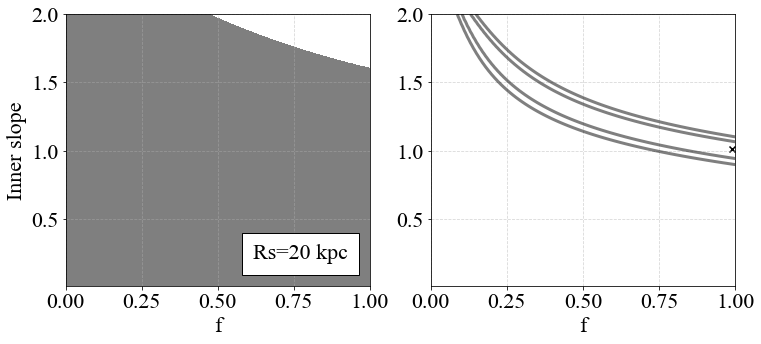

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

ax[0].contourf(F, GAMMA, p_gammaf, levels=[0.05, 1], colors="black", linewidths=3., alpha=0.5)
ax[0].grid(which="both", ls="--", alpha=0.5)

ax[0].set_ylabel("Inner slope")
ax[0].set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[0].add_artist(text_box)

ax[1].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma, chi2min_gammaf+chi2_2sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].scatter(f[pos_min_gammaf[1]], gamma[pos_min_gammaf[0]], marker="x", color="k")

ax[1].set_xlabel("f")

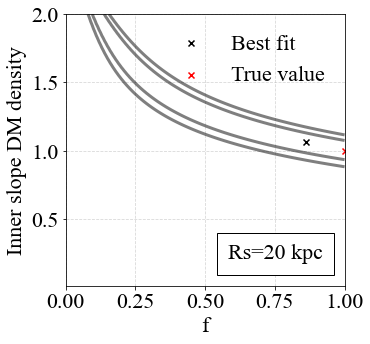

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

ax.contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma, chi2min_gammaf+chi2_2sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax.grid(which="both", ls="--", alpha=0.5)
ax.scatter(f[pos_min_gammaf[1]], gamma[pos_min_gammaf[0]], marker="x", color="k", label="Best fit")
ax.scatter(1., 1., marker="x", color="r", label="True value")

ax.set_ylabel("Inner slope DM density")
ax.set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax.add_artist(text_box)
ax.legend(frameon=False)

#fig.savefig("./Figs/gamma_f.pdf", bbox_inches="tight")

In [70]:
step = 0.01
f = np.arange(0, 1+step, step)
step = 0.01
gamma = np.arange(0.01, 2+step, step)

heat_DM_gammaf1 = np.zeros((len(gamma), len(f)))
heat_DM_gammaf2 = np.zeros((len(gamma), len(f)))

for i in range(len(gamma)):
    for j in range(len(f)):
        heat_DM_gammaf1[i][j] = heat_DM(4., f=f[j], R=R_jup, M=75*M_jup, parameters=[gamma[i], 20., 0.42])
        heat_DM_gammaf2[i][j] = heat_DM(5., f=f[j], R=R_jup, M=75*M_jup, parameters=[gamma[i], 20., 0.42])

<ipython-input-65-eba144af749f>:11: RuntimeWarning: divide by zero encountered in log10
  cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), levels=levels, cmap=cmocean.cm.thermal)
<ipython-input-65-eba144af749f>:13: RuntimeWarning: divide by zero encountered in log10
  m.set_array(np.log10(heat_DM_gammaf1*1e-12))
<ipython-input-65-eba144af749f>:19: RuntimeWarning: divide by zero encountered in log10
  cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), levels=levels, cmap=cmocean.cm.thermal)


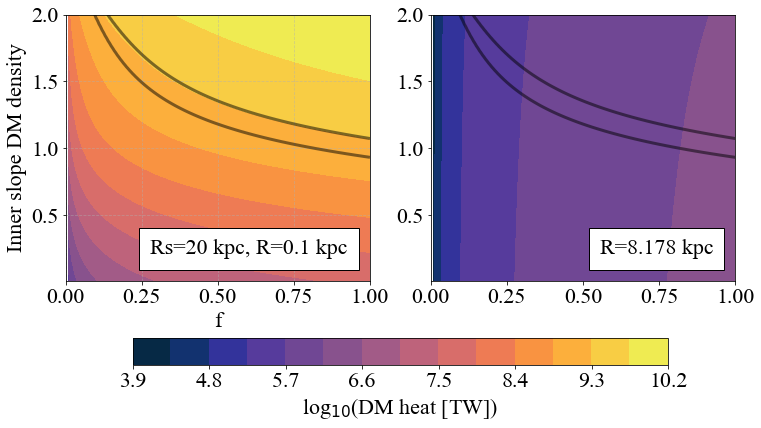

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

ax[0].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax[1].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)

levels=np.linspace(3.9, 10.2, 15)
cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), levels=levels, cmap=cmocean.cm.thermal)
m = plt.cm.ScalarMappable(cmap=cmocean.cm.thermal)
m.set_array(np.log10(heat_DM_gammaf1*1e-12))
m.set_clim(3.9, 10.2)
cbar = plt.colorbar(m, boundaries=levels, orientation="horizontal", ax=ax.ravel().tolist(), 
                    shrink=0.8)
cbar.set_label(r"log$_{10}$(DM heat [TW])")

cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), levels=levels, cmap=cmocean.cm.thermal)
#cbar = fig.colorbar(cs, ax=ax[1], orientation="horizontal")
#cbar.set_label(r"log$_{10}$(DM heat [TW])")

ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylabel("Inner slope DM density")
ax[0].set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc, R=0.1 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[0].add_artist(text_box)

text_box = AnchoredText("R=8.178 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[1].add_artist(text_box)

fig.savefig("./Figs/gamma_f_heatDM.pdf", bbox_inches="tight")

<ipython-input-69-d3ad31feeb47>:11: RuntimeWarning: divide by zero encountered in log10
  cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), levels=levels, cmap=cmocean.cm.thermal)
<ipython-input-69-d3ad31feeb47>:13: RuntimeWarning: divide by zero encountered in log10
  m.set_array(np.log10(heat_DM_gammaf1*1e-12))
<ipython-input-69-d3ad31feeb47>:19: RuntimeWarning: divide by zero encountered in log10
  cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), levels=levels, cmap=cmocean.cm.thermal)


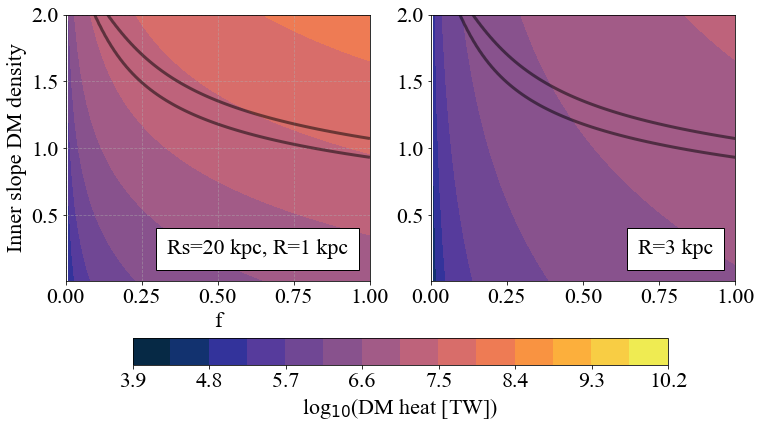

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

ax[0].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax[1].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)

levels=np.linspace(3.9, 10.2, 15)
cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), levels=levels, cmap=cmocean.cm.thermal)
m = plt.cm.ScalarMappable(cmap=cmocean.cm.thermal)
m.set_array(np.log10(heat_DM_gammaf1*1e-12))
m.set_clim(3.9, 10.2)
cbar = plt.colorbar(m, boundaries=levels, orientation="horizontal", ax=ax.ravel().tolist(), 
                    shrink=0.8)
cbar.set_label(r"log$_{10}$(DM heat [TW])")

cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), levels=levels, cmap=cmocean.cm.thermal)

ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylabel("Inner slope DM density")
ax[0].set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc, R=1 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[0].add_artist(text_box)

text_box = AnchoredText("R=3 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[1].add_artist(text_box)

<ipython-input-43-e2281bb5443a>:10: RuntimeWarning: divide by zero encountered in log10
  cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), cmap=cmocean.cm.thermal)
<ipython-input-43-e2281bb5443a>:14: RuntimeWarning: divide by zero encountered in log10
  cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), cmap=cmocean.cm.thermal)


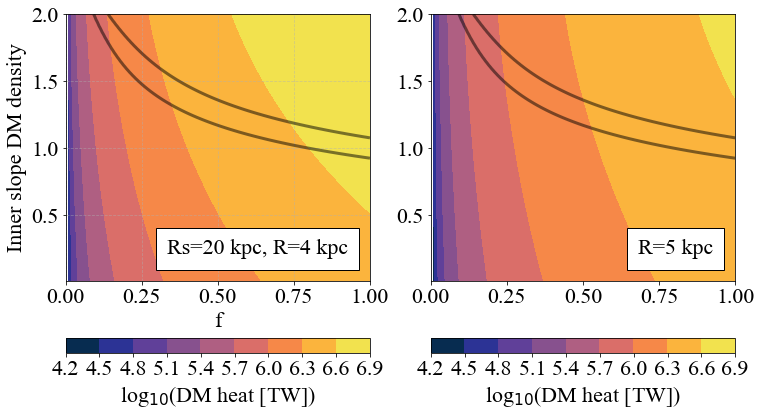

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

ax[0].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax[1].contour(F, GAMMA, chi2_gammaf, levels=[0, chi2min_gammaf+chi2_1sigma], 
               colors="black", linewidths=3., alpha=0.5)

levels=np.linspace(3.9, 10.2, 15)
cs = ax[0].contourf(F, GAMMA, np.log10(heat_DM_gammaf1*1e-12), levels=levels, cmap=cmocean.cm.thermal)
m = plt.cm.ScalarMappable(cmap=cmocean.cm.thermal)
m.set_array(np.log10(heat_DM_gammaf1*1e-12))
m.set_clim(3.9, 10.2)
cbar = plt.colorbar(m, boundaries=levels, orientation="horizontal", ax=ax.ravel().tolist(), 
                    shrink=0.8)
cbar.set_label(r"log$_{10}$(DM heat [TW])")

cs = ax[1].contourf(F, GAMMA, np.log10(heat_DM_gammaf2*1e-12), levels=levels, cmap=cmocean.cm.thermal)

ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylabel("Inner slope DM density")
ax[0].set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc, R=4 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[0].add_artist(text_box)

text_box = AnchoredText("R=5 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[1].add_artist(text_box)

<ipython-input-252-90ad66b9f133>:5: UserWarning: linewidths is ignored by contourf
  ax[0].contourf(RS, GAMMA, p_gammars, levels=[0.05, 1], colors="black", linewidths=3., alpha=0.4)


Text(0.5, 0, 'scale radius [kpc]')

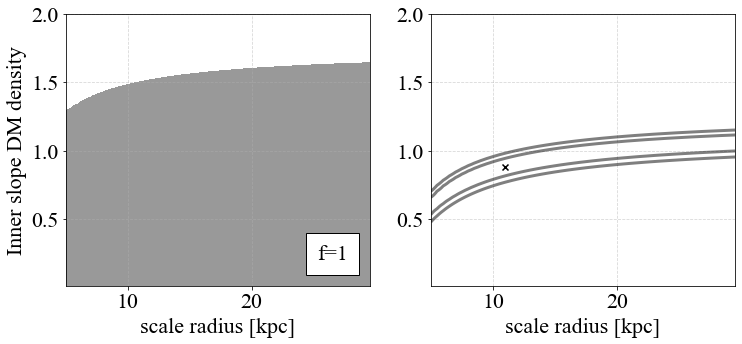

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

GAMMA, RS = np.meshgrid(gamma, rs, indexing="ij")

ax[0].contourf(RS, GAMMA, p_gammars, levels=[0.05, 1], colors="black", linewidths=3., alpha=0.4)
ax[0].grid(which="both", ls="--", alpha=0.5)

ax[0].set_ylabel("Inner slope DM density")
ax[0].set_xlabel("scale radius [kpc]")

text_box = AnchoredText("f=1", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax[0].add_artist(text_box)

ax[1].contour(RS, GAMMA, chi2_gammars, levels=[0, chi2min_gammars+chi2_1sigma, chi2min_gammars+chi2_2sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].scatter(rs[pos_min_gammars[1]], gamma[pos_min_gammars[0]], marker="x", color="k")
ax[1].set_xlabel("scale radius [kpc]")

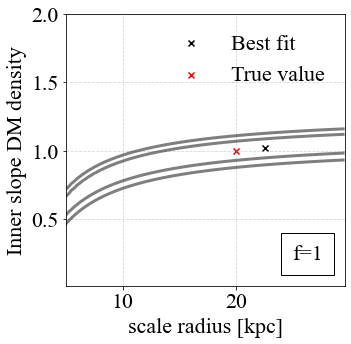

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

GAMMA, RS = np.meshgrid(gamma, rs, indexing="ij")

ax.contour(RS, GAMMA, chi2_gammars, levels=[0, chi2min_gammars+chi2_1sigma, chi2min_gammars+chi2_2sigma], 
               colors="black", linewidths=3., alpha=0.5)
ax.grid(which="both", ls="--", alpha=0.5)
ax.scatter(rs[pos_min_gammars[1]], gamma[pos_min_gammars[0]], marker="x", color="k", label="Best fit")
ax.scatter(20., 1., marker="x", color="red", label="True value")

ax.set_ylabel("Inner slope DM density")
ax.set_xlabel("scale radius [kpc]")
text_box = AnchoredText("f=1", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax.add_artist(text_box)
ax.legend(frameon=False)

fig.savefig("./Figs/gamma_rs.pdf", bbox_inches="tight")

### Generalize for increasing number of observed exoplanets

In [11]:
np.random.seed(42)

size = [200, 1000, 5000, 10000]
step = 0.01
f = np.arange(0, 1+step, step)
step = 0.01
gamma = np.arange(0.01, 2+step, step)

chi2_gammaf    = {}
chi2min_gammaf = {}
pos_min_gammaf = {}

for s in size:
    r_obs       = loguniform.rvs(0.1, 8.178, size=s)
    gamma_model = 1
    f_model     = 1
    M_model     = 75*M_jup
    R_model     = R_jup
    heat_int    = 1.1e21 # W
    t_fiducial  = temperature(r_obs, heat_int, f=f_model, R=R_model, M=M_model, 
                          parameters=[gamma_model, 20., 0.42], epsilon=1)
    sigma_obs = 0.1*t_fiducial
    t_obs     = t_fiducial + 0.1*np.random.normal(loc=0, scale=(0.1*t_fiducial), size=len(t_fiducial))

    chi2_gammaf[s] = np.zeros((len(gamma), len(f)))


    dof = len(t_obs)

    for i in range(len(gamma)):
        for j in range(len(f)):
            t_model = temperature(r_obs, 1.1e21, f=f[j], M=75*M_jup, parameters=[gamma[i], 20., 0.42])
            chi2_score = np.sum(np.power((t_obs - t_model)/sigma_obs, 2))
            chi2_gammaf[s][i][j] = chi2_score
    pos_min_gammaf[s] = np.where(chi2_gammaf[s] == np.min(chi2_gammaf[s]))
    chi2min_gammaf[s] = chi2_gammaf[s][pos_min_gammaf[s]]

In [38]:
np.random.seed(42)

size = [200, 1000, 5000, 10000]
step = 0.01
gamma = np.arange(0.01, 2+step, step)
step = 0.5
rs = np.arange(5, 30, step)

chi2_gammars = {}
pos_min_gammars = {}
chi2min_gammars = {}

dof = len(t_obs)
for s in size: 
    r_obs       = loguniform.rvs(0.1, 8.178, size=s)
    gamma_model = 1
    f_model     = 1
    M_model     = 75*M_jup
    R_model     = R_jup
    heat_int    = 1.1e21 # W
    t_fiducial  = temperature(r_obs, heat_int, f=f_model, R=R_model, M=M_model, 
                          parameters=[gamma_model, 20., 0.42], epsilon=1)
    sigma_obs = 0.1*t_fiducial
    t_obs     = t_fiducial + 0.1*np.random.normal(loc=0, scale=(0.1*t_fiducial), size=len(t_fiducial))
    
    chi2_gammars[s] = np.zeros((len(gamma), len(rs)))
    
    for i in range(len(gamma)):
        for j in range(len(rs)):
            t_model = temperature(r_obs, 1.1e21, f=1, M=75*M_jup, parameters=[gamma[i], rs[j], 0.42])
            chi2_score = np.sum(np.power((t_obs - t_model)/sigma_obs, 2))
            chi2_gammars[s][i][j] = chi2_score
    pos_min_gammars[s] = np.where(chi2_gammars[s] == np.min(chi2_gammars[s]))
    chi2min_gammars[s] = chi2_gammars[s][pos_min_gammars[s]]

In [34]:
import pickle
output = open("./chi2_gammaf_sizes", "wb")
pickle.dump(chi2_gammaf, output)
output = open("./chi2min_gammaf_sizes", "wb")
pickle.dump(chi2min_gammaf, output)
output = open("./pos_min_gammaf_sizes", "wb")
pickle.dump(chi2min_gammaf, output)

In [7]:
output = open("./chi2_gammaf_sizes", "rb")
chi2min_gammaf = pickle.load(output)
output = open("./pos_min_gammaf_sizes", "rb")
pos_min_gammaf = pickle.load(output)

size = [200, 1000, 5000, 10000]
step = 0.01
f = np.arange(0, 1+step, step)
step = 0.01
gamma = np.arange(0.01, 2+step, step)

<ipython-input-23-e3a8378d3876>:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(F, GAMMA, chi2_gammaf[s], levels=[0, chi2min_gammaf[s]+chi2_1sigma],
No handles with labels found to put in legend.


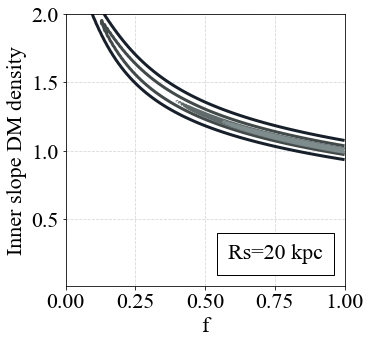

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")
cmap = plt.get_cmap("Greys")
i = 0
colors = ["#17202a", "#424949", "#616a6b", "#7f8c8d"]

for s in size:
    ax.contour(F, GAMMA, chi2_gammaf[s], levels=[0, chi2min_gammaf[s]+chi2_1sigma], 
               colors=colors[i], linewidths=3., label=s)
    #if s==size[0]:
    #    ax.scatter(f[pos_min_gammaf[s][1]], gamma[pos_min_gammaf[s][0]], marker="x", color="k", label="Best fit")
    #    ax.scatter(1., 1., marker="x", color="r", label="True value")
    #else:
    #    ax.scatter(f[pos_min_gammaf[s][1]], gamma[pos_min_gammaf[s][0]], marker="x", color="k")
    #    ax.scatter(1., 1., marker="x", color="r",)
    i = i+1
    
ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel("Inner slope DM density")
ax.set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax.add_artist(text_box)
ax.legend(frameon=False)

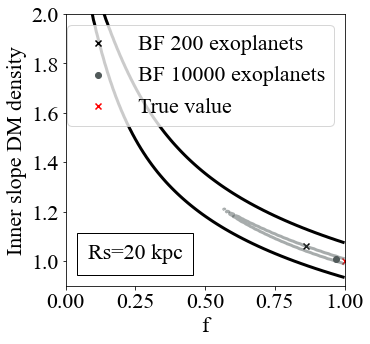

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

GAMMA, F = np.meshgrid(gamma, f, indexing="ij")

s=size[0]
ax.contour(F, GAMMA, chi2_gammaf[s], levels=[0, chi2min_gammaf[s]+chi2_1sigma], 
               colors="black", linewidths=3.)
ax.scatter(f[pos_min_gammaf[s][1]], gamma[pos_min_gammaf[s][0]], marker="x", color="k",
           label="BF 200 exoplanets")

s=size[-1]
ax.contour(F, GAMMA, chi2_gammaf[s], levels=[0, chi2min_gammaf[s]+chi2_1sigma], 
               colors="#515a5a", linewidths=3., alpha=0.5)
ax.scatter(f[pos_min_gammaf[s][1]], gamma[pos_min_gammaf[s][0]], marker="o", color="#515a5a", 
           label="BF 10000 exoplanets")

ax.scatter(1., 1., marker="x", color="r", label="True value")

ax.set_ylabel("Inner slope DM density")
ax.set_xlabel("f")
text_box = AnchoredText("Rs=20 kpc", frameon=True, loc=3, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax.add_artist(text_box)
ax.legend(frameon=True)
ax.set_ylim([0.9, 2])

fig.savefig("./Figs/gamma_f_size_stat.pdf", bbox_inches="tight")

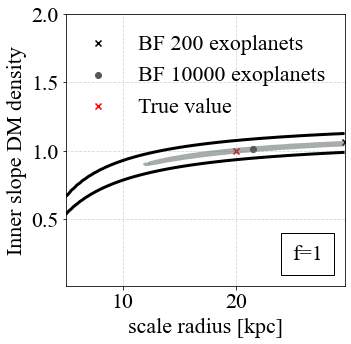

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

GAMMA, RS = np.meshgrid(gamma, rs, indexing="ij")

s=size[0]
ax.contour(RS, GAMMA, chi2_gammars[s], levels=[0, chi2min_gammars[s]+chi2_1sigma], 
               colors="black", linewidths=3.)
ax.grid(which="both", ls="--", alpha=0.5)
ax.scatter(rs[pos_min_gammars[s][1]], gamma[pos_min_gammars[s][0]], marker="x", color="k", label="BF 200 exoplanets")

s=size[-1]
ax.contour(RS, GAMMA, chi2_gammars[s], levels=[0, chi2min_gammars[s]+chi2_1sigma], 
               colors="#515a5a", linewidths=3., alpha=0.5)
ax.scatter(rs[pos_min_gammars[s][1]], gamma[pos_min_gammars[s][0]], marker="o", color="#515a5a", 
           label="BF 10000 exoplanets")

ax.scatter(20., 1., marker="x", color="red", label="True value")

ax.set_ylabel("Inner slope DM density")
ax.set_xlabel("scale radius [kpc]")
text_box = AnchoredText("f=1", frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white')
ax.add_artist(text_box)
ax.legend(frameon=False)

fig.savefig("./Figs/gamma_rs_stat.pdf", bbox_inches="tight")